In [1]:
%matplotlib inline
import editdistance
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal

from aux import zscore
from disp import set_plot, plot_b

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

NRL_MDLS = ['lin', 'ln', 'dyn']
COLORS = ['b', 'm', 'k']
FPCAS = [
    f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_pca_nm91_zh23/pca_results.npy'
    for nrl_mdl in NRL_MDLS
]

In [2]:
DF_LIN_PARAM = pd.read_csv('data/simple/neur/baker_lin_fit_param.csv')
DF_LN_PARAM = pd.read_csv('data/simple/neur/baker_ln_fit_param.csv')
DF_DYN_PARAM = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

H_S_COLS = [f'IT_H_S_{it}' for it in range(NT_H_DN)]
H_P_COLS = [f'IT_H_P_{it}' for it in range(NT_H_DN)]

EXPT_IDS = DF_LIN_PARAM['EXPT_ID']

In [3]:
# linear simulation
# filters (downsampled)
hs_lin_dn_s = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_lin_dn_p = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_lin_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_s])[:-1]) for h_lin_dn_s in hs_lin_dn_s])
hs_lin_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_p])[:-1]) for h_lin_dn_p in hs_lin_dn_p])

def smlt_lin_(i_s, i_p, h_s, h_p):
    """Single neuron"""
    r = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
        + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    return r


def smlt_lin(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p) in enumerate(zip(hs_lin_s, hs_lin_p)):
        rs[:, cr] = smlt_lin_(i_s, i_p, h_s, h_p)
        
    return rs


# linear-nonlinear simulation
# filters (downsampled)
hs_ln_dn_s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_ln_dn_p = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_ln_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_s])[:-1]) for h_ln_dn_s in hs_ln_dn_s])
hs_ln_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_p])[:-1]) for h_ln_dn_p in hs_ln_dn_p])

r_mins = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MIN'] for expt_id in EXPT_IDS])
r_maxs = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MAX'] for expt_id in EXPT_IDS])
z_0s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['Z_0'] for expt_id in EXPT_IDS])
betas = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['BETA'] for expt_id in EXPT_IDS])

def smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta):
    """Single neuron."""
    z = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


def smlt_ln(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p, r_min, r_max, z_0, beta) in enumerate(zip(hs_ln_s, hs_ln_p, r_mins, r_maxs, z_0s, betas)):
        rs[:, cr] = smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta)
        
    return rs


# nonlinear adaptive simulation
tau_rs = np.array(DF_DYN_PARAM['TAU_R'])
tau_as = np.array(DF_DYN_PARAM['TAU_A'])
x_ss = np.array(DF_DYN_PARAM['X_S'])
x_ps = np.array(DF_DYN_PARAM['X_P'])

def smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

def smlt_dyn(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (tau_r, tau_a, x_s, x_p) in enumerate(zip(tau_rs, tau_as, x_ss, x_ps)):
        rs[:, cr] = smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p)
        
    return rs

In [4]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

# Random song snippets

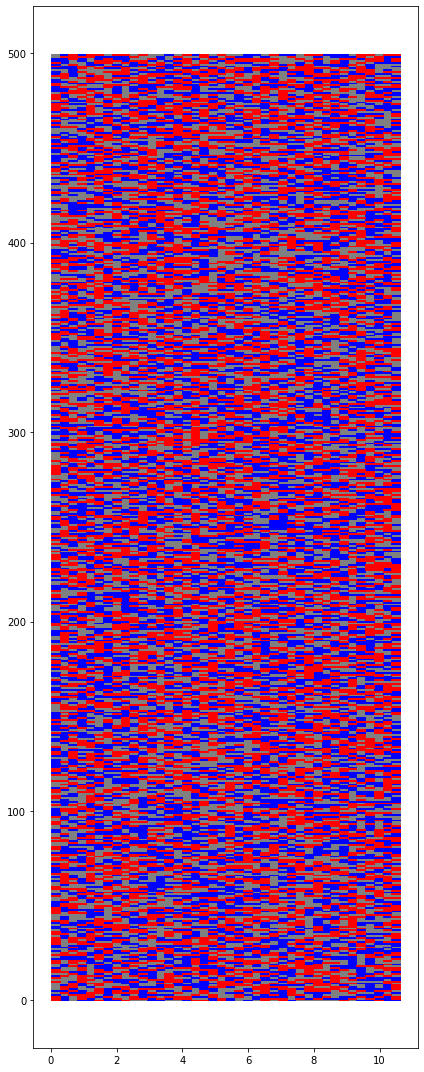

In [5]:
sngs = []
IT_SEG = 8
NSEG = 40
NSNG = 500

t = np.arange(0, NSEG*IT_SEG*DT, DT)
for _ in range(NSNG):
    sng = []
    for iseg in range(NSEG):
        next_mode = np.random.randint(0, 3)
        sng.extend((IT_SEG*[next_mode]))
    sngs.append(np.array(sng).astype(int))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])

In [6]:
sngs_str = [
    ''.join([str(x) for x in sng]) for sng in sngs
]
ds_hm = np.nan * np.zeros((NSNG, NSNG))  # hamming distance between songs
ds_lv = np.nan * np.zeros((NSNG, NSNG))  # levenshtein distance between songs


for i in range(NSNG):
    for j in range(i+1, NSNG):
        d_hm = np.sum(sngs[i] != sngs[j])
        ds_hm[i, j] = d_hm
        
        d_lv = editdistance.eval(sngs_str[i], sngs_str[j])
        ds_lv[i, j] = d_lv
        
ds_hm_flat = ds_hm.flatten()
ds_lv_flat = ds_lv.flatten()

d_hm_min = np.nanmin(ds_hm)
d_hm_max = np.nanmax(ds_hm)

d_lv_min = np.nanmin(ds_lv)
d_lv_max = np.nanmax(ds_lv)

Text(0, 0.5, 'Edit dist')

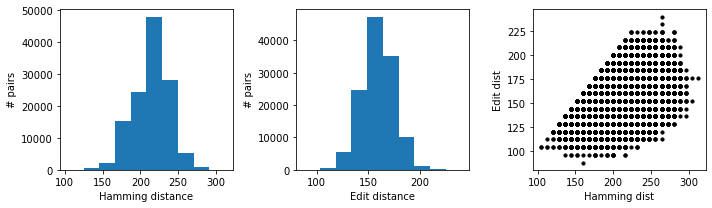

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
axs[0].hist(ds_hm_flat, bins=10)
axs[0].set_xlabel('Hamming distance')
axs[0].set_ylabel('# pairs')
axs[1].hist(ds_lv_flat, bins=10)
axs[1].set_xlabel('Edit distance')
axs[1].set_ylabel('# pairs')
axs[2].scatter(ds_hm_flat, ds_lv_flat, s=10, c='k')
axs[2].set_xlabel('Hamming dist')
axs[2].set_ylabel('Edit dist')

In [8]:
# compute responses of different neural models
import sys
rsps = {nrl_mdl: np.nan*np.zeros((NSNG, 224)) for nrl_mdl in NRL_MDLS}

for csng, sng in enumerate(sngs):
    sys.stdout.write('.')
    r_lin = smlt_lin(sng)
    r_ln = smlt_ln(sng)
    r_dyn = smlt_dyn(sng)
    
    # save final timepoints
    rsps['lin'][csng, :] = r_lin[-1, :]
    rsps['ln'][csng, :] = r_ln[-1, :]
    rsps['dyn'][csng, :] = r_dyn[-1, :]

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
# compute neural distances
ds_nrl = {nrl_mdl: np.nan * np.eye(NSNG) for nrl_mdl in NRL_MDLS}

for nrl_mdl in NRL_MDLS:
    for i in range(NSNG):
        for j in range(i+1, NSNG):
            d_nrl = np.sqrt(np.mean((rsps[nrl_mdl][i, :] - rsps[nrl_mdl][j, :])**2))
            ds_nrl[nrl_mdl][i, j] = d_nrl

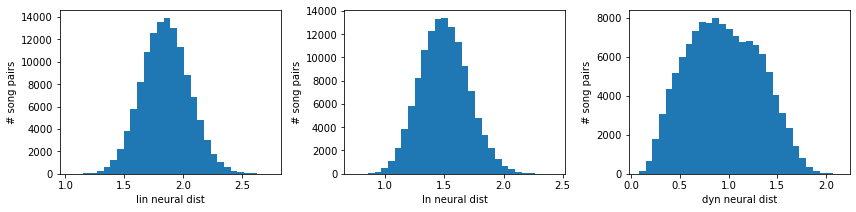

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
for nrl_mdl, ax in zip(NRL_MDLS, axs):
    ax.hist(ds_nrl[nrl_mdl].flatten(), bins=30)
    ax.set_xlabel(f'{nrl_mdl} neural dist')
    ax.set_ylabel('# song pairs')

Text(0, 0.5, 'Edit dist')

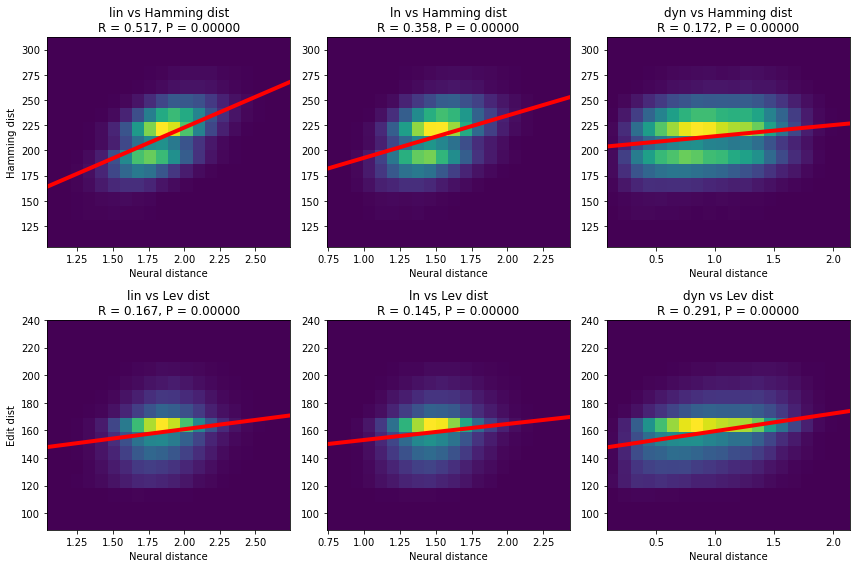

In [11]:
from disp import get_line

fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

bins_hm = np.linspace(d_hm_min, d_hm_max, 16)
bins_lv = np.linspace(d_lv_min, d_lv_max, 16)

for cnrl_mdl, nrl_mdl in enumerate(NRL_MDLS):
    ds_nrl_flat = ds_nrl[nrl_mdl].flatten()
    bins_nrl = np.linspace(np.nanmin(ds_nrl[nrl_mdl]), np.nanmax(ds_nrl[nrl_mdl]), 21)
    
    axs[0, cnrl_mdl].hist2d(ds_nrl_flat, ds_hm_flat, bins=(bins_nrl, bins_hm))
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_nrl_flat, ds_hm_flat)
    axs[0, cnrl_mdl].plot(x_ln, y_ln, c='r', lw=4)
    axs[0, cnrl_mdl].set_title(f'{nrl_mdl} vs Hamming dist\nR = {r:.3f}, P = {p:.5f}')
    axs[0, cnrl_mdl].set_xlabel('Neural distance')
    
    axs[1, cnrl_mdl].hist2d(ds_nrl_flat, ds_lv_flat, bins=(bins_nrl, bins_lv))
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_nrl_flat, ds_lv_flat)
    axs[1, cnrl_mdl].plot(x_ln, y_ln, c='r', lw=4)
    axs[1, cnrl_mdl].set_title(f'{nrl_mdl} vs Lev dist\nR = {r:.3f}, P = {p:.5f}')
    axs[1, cnrl_mdl].set_xlabel('Neural distance')
    
axs[0, 0].set_ylabel('Hamming dist')
axs[1, 0].set_ylabel('Edit dist')

# Natural song snippets

In [5]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [6]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [7]:
from aux import get_seg
# get snippets

nt = int(round(10*FPS))
min_gap = int(round(5*FPS))
min_frac_sing = 0

sngs = []  # song snippets

for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs.extend(segs)
    
sngs = np.array(sngs)

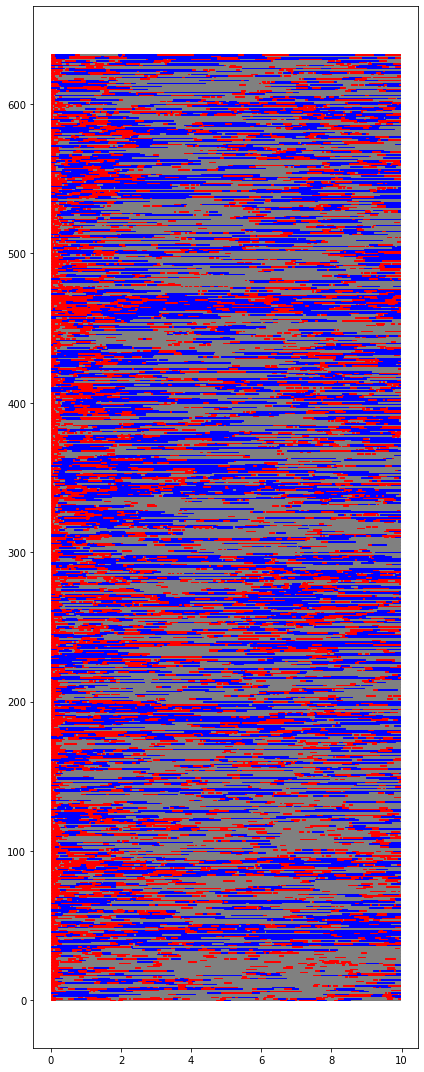

In [8]:
t = np.arange(nt)*DT
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])

In [9]:
nsng = len(sngs)

sngs_str = [
    ''.join([str(x) for x in sng]) for sng in sngs
]
ds_hm = np.nan * np.zeros((nsng, nsng))  # hamming distance between songs
ds_lv = np.nan * np.zeros((nsng, nsng))  # levenshtein distance between songs


for i in range(nsng):
    for j in range(i+1, nsng):
        d_hm = np.sum(sngs[i] != sngs[j])
        ds_hm[i, j] = d_hm
        
        d_lv = editdistance.eval(sngs_str[i], sngs_str[j])
        ds_lv[i, j] = d_lv
        
ds_hm_flat = ds_hm.flatten()
ds_lv_flat = ds_lv.flatten()

d_hm_min = np.nanmin(ds_hm)
d_hm_max = np.nanmax(ds_hm)

d_lv_min = np.nanmin(ds_lv)
d_lv_max = np.nanmax(ds_lv)

Text(0, 0.5, 'Edit dist')

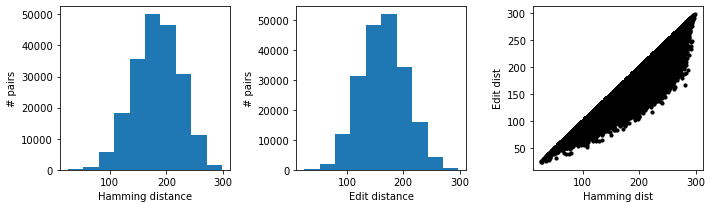

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
axs[0].hist(ds_hm_flat, bins=10)
axs[0].set_xlabel('Hamming distance')
axs[0].set_ylabel('# pairs')
axs[1].hist(ds_lv_flat, bins=10)
axs[1].set_xlabel('Edit distance')
axs[1].set_ylabel('# pairs')
axs[2].scatter(ds_hm_flat, ds_lv_flat, s=10, c='k')
axs[2].set_xlabel('Hamming dist')
axs[2].set_ylabel('Edit dist')

In [11]:
# compute responses of different neural models
import sys
rsps = {nrl_mdl: np.nan*np.zeros((nsng, 224)) for nrl_mdl in NRL_MDLS}

for csng, sng in enumerate(sngs):
    sys.stdout.write('.')
    r_lin = smlt_lin(sng)
    r_ln = smlt_ln(sng)
    r_dyn = smlt_dyn(sng)
    
    # save final timepoints
    rsps['lin'][csng, :] = r_lin[-1, :]
    rsps['ln'][csng, :] = r_ln[-1, :]
    rsps['dyn'][csng, :] = r_dyn[-1, :]

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
# compute neural distances
ds_nrl = {nrl_mdl: np.nan * np.eye(nsng) for nrl_mdl in NRL_MDLS}

for nrl_mdl in NRL_MDLS:
    for i in range(nsng):
        for j in range(i+1, nsng):
            d_nrl = np.sqrt(np.mean((rsps[nrl_mdl][i, :] - rsps[nrl_mdl][j, :])**2))
            ds_nrl[nrl_mdl][i, j] = d_nrl

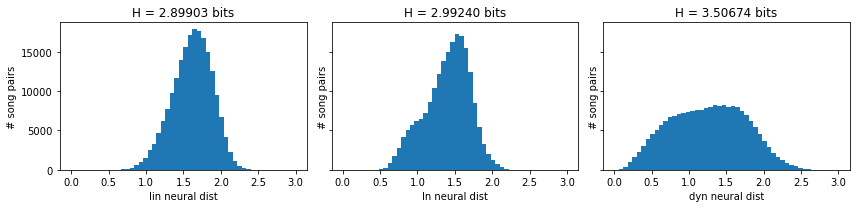

In [13]:
from scipy import stats
fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True, sharey=True)
bins = np.linspace(0, 3, 51)
for nrl_mdl, ax in zip(NRL_MDLS, axs):
    cts = np.histogram(ds_nrl[nrl_mdl].flatten(), bins=bins, density=True)[0]
    cts /= cts.sum()
    
    ax.hist(ds_nrl[nrl_mdl].flatten(), bins=bins)
    ax.set_xlabel(f'{nrl_mdl} neural dist')
    ax.set_ylabel('# song pairs')
    ax.set_title(f'H = {stats.entropy(cts):.5f} bits')

Text(0, 0.5, 'Edit dist')

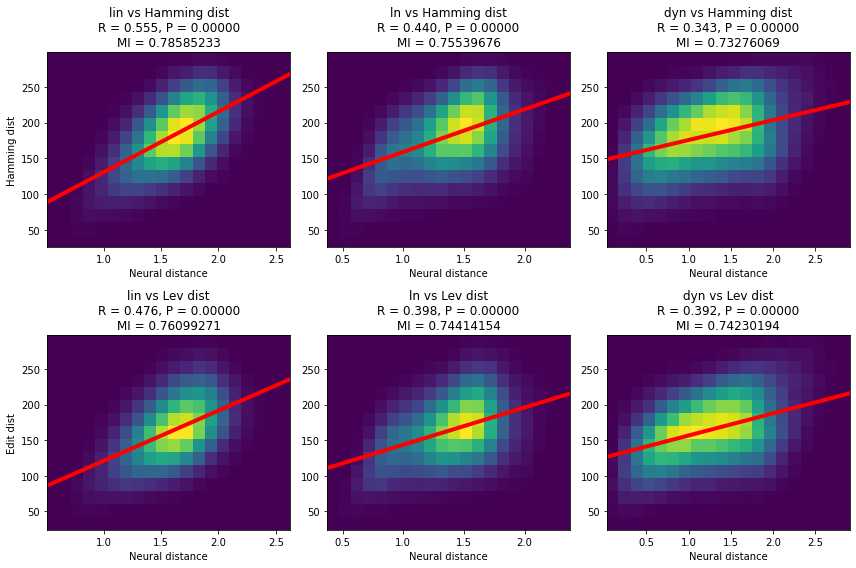

In [14]:
from disp import get_line
from sklearn.metrics import mutual_info_score

fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

bins_hm = np.linspace(d_hm_min, d_hm_max, 16)
bins_lv = np.linspace(d_lv_min, d_lv_max, 16)

ids_hm = np.digitize(ds_hm_flat, bins_hm)
ids_lv = np.digitize(ds_lv_flat, bins_lv)

for cnrl_mdl, nrl_mdl in enumerate(NRL_MDLS):
    ds_nrl_flat = ds_nrl[nrl_mdl].flatten()
    mvalid = (~np.isnan(ds_nrl_flat)) & (~np.isnan(ds_hm_flat)) & (~np.isnan(ds_lv_flat))
    
    bins_nrl = np.linspace(np.nanmin(ds_nrl[nrl_mdl]), np.nanmax(ds_nrl[nrl_mdl]), 21)
    ids_nrl = np.digitize(ds_nrl_flat, bins_nrl)
    
    axs[0, cnrl_mdl].hist2d(ds_nrl_flat, ds_hm_flat, bins=(bins_nrl, bins_hm))
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_nrl_flat, ds_hm_flat)
    axs[0, cnrl_mdl].plot(x_ln, y_ln, c='r', lw=4)
    
    # compute mutual info
    mi_nrl_hm = mutual_info_score(ids_nrl, ids_hm)
    
    axs[0, cnrl_mdl].set_title(f'{nrl_mdl} vs Hamming dist\nR = {r:.3f}, P = {p:.5f}\nMI = {mi_nrl_hm:.8f}')
    axs[0, cnrl_mdl].set_xlabel('Neural distance')
    
    axs[1, cnrl_mdl].hist2d(ds_nrl_flat, ds_lv_flat, bins=(bins_nrl, bins_lv))
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_nrl_flat, ds_lv_flat)
    axs[1, cnrl_mdl].plot(x_ln, y_ln, c='r', lw=4)
    
    # compute mutual info
    mi_nrl_lv = mutual_info_score(ids_nrl, ids_lv)
    
    axs[1, cnrl_mdl].set_title(f'{nrl_mdl} vs Lev dist\nR = {r:.3f}, P = {p:.5f}\nMI = {mi_nrl_lv:.8f}')
    axs[1, cnrl_mdl].set_xlabel('Neural distance')
    
axs[0, 0].set_ylabel('Hamming dist')
axs[1, 0].set_ylabel('Edit dist')